In [1]:
import sys
import os

parent = os.path.dirname(os.path.realpath('../'))
sys.path.append(parent)

import numpy as np
import scipy
import tqdm
import open3d as o3d
import matplotlib.pyplot as plt
import glob

from core import *
from utils import phantom_builder
from utils import geometry

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# test_phantom = phantom.Phantom.load(f'{parent}/assets/hando_phantom')

In [3]:
# plt.imshow(test_phantom.get_complete()[0, :, :, 200], vmin=1500, vmax=2000)

In [4]:
# plt.imshow(test_phantom.get_complete()[0, 90, :, :], vmin=1500, vmax=2000)

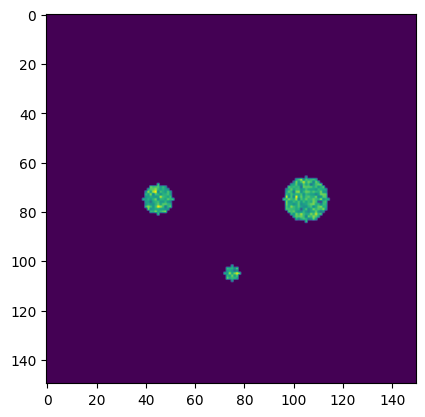

In [5]:
test_phantom = phantom.Phantom(source_path = None,
            voxel_dims = (0.5e-3,0.5e-3,0.5e-3),
            matrix_dims = (150,150,100),
            baseline = (1500, 1000),
            seed = 5678,)

blood = tissue.Tissue(name='blood', c=1578, rho=1060, sigma=5.3, scale=0.00001, label=1)
myocardium = tissue.Tissue(name='myocardium', c=1561.3, rho=1081, sigma=50, scale=0.0001, label=2)
fat = tissue.Tissue(name='fat', c=1450, rho=920, sigma=0, scale=1, label=3)

pos = 0.015

test_phantom.add_tissue(fat, mask=np.ones(test_phantom.matrix_dims))
test_phantom.add_tissue_sphere((pos,0,0), 3, myocardium)
test_phantom.add_tissue_sphere((0,pos,0), 9, myocardium)
test_phantom.add_tissue_sphere((0,-pos,0), 6, myocardium)
# test_phantom.add_tissue_sphere((0,0,0), 3, myocardium)
test_phantom.set_default_tissue('fat')

plt.imshow(test_phantom.get_complete()[0,:,:,test_phantom.get_complete().shape[3]//2])

In [6]:
num_transducers = 3
transducers = [transducer.Planewave(max_frequency=0.75e6,
                                    elements = 50, 
                                    width = 40e-3,
                                    height =  20e-3,
                                    sensor_sampling_scheme = 'not_centroid', 
                                    sweep = 0,
                                    ray_num = 1, 
                                    imaging_ndims = 2,
                                    focus_elevation = 60e-3,
                                    ) for i in range(num_transducers)]

# transducers = [transducer.Planewave(max_frequency=1e6,
#                                     elements = 32, 
#                                     width = 20e-3,
#                                     height =  10e-3,
#                                     sensor_sampling_scheme = 'not_centroid', 
#                                     sweep = np.pi/6,
#                                     ray_num = 30, 
#                                     imaging_ndims = 2,
#                                     focus_elevation = 50e-3,
#                                     ) for i in range(num_transducers)]

# transducers = [transducer.Focused(max_frequency = 1e6,
#                                   elements = 128, 
#                                   width = 10e-3,
#                                   height =  10e-3,
#                                   sensor_sampling_scheme = 'not_centroid', 
#                                   sweep = np.pi/3,
#                                   ray_num = 16,
#                                   imaging_ndims = 2,
#                                   focus_azimuth = 60-3,
#                                   focus_elevation = 80-3) for i in range(num_transducers)]


for t in transducers:
    t.make_sensor_coords(1540) # test_phantom.baseline[0]

test_transducer_set = transducer_set.TransducerSet(transducers, seed=8888)

In [7]:
rotations = [geometry.Transform((r,0,0),(0,0,0)) for r in np.linspace(0, 2 * np.pi / 2.8, num_transducers, endpoint=False)]
positions = [rot.apply_to_point((-0.05,0,0)) for rot in rotations]

for i in range(num_transducers):
    rotations[i].translation = positions[i]
    test_transducer_set.assign_pose(i, rotations[i])

In [8]:
test_sensor = sensor.Sensor(transducer_set=test_transducer_set, aperture_type='transmit_as_receive')
# test_sensor = sensor.Sensor(transducer_set=test_transducer_set, aperture_type='extended_aperture')

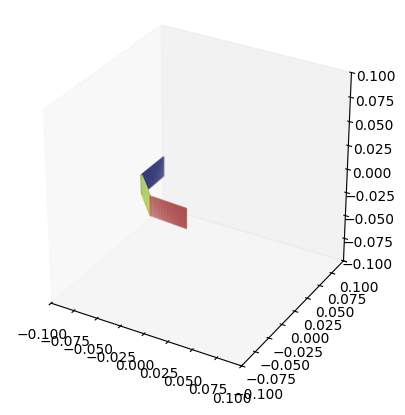

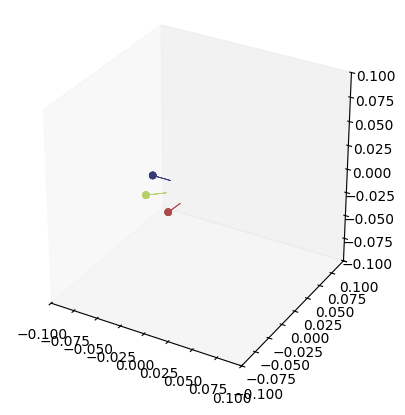

In [9]:
test_transducer_set.plot_transducer_coords()
test_transducer_set.plot_transducer_fovs()

In [10]:
# simprops = simulation.SimProperties(
#                 grid_size   = (90e-3,20e-3,20e-3),
#                 voxel_size  = (0.5e-3,0.5e-3,0.5e-3),
#                 PML_size    = (32,8,8),
#                 PML_alpha   = 2,
#                 t_end       = 12e-5,           # [s]
#                 bona        = 6,               # parameter b/a determining degree of nonlinear acoustic effects
#                 alpha_coeff = 0.5, 	           # [dB/(MHz^y cm)]
#                 alpha_power = 1.5,
#                 grid_lambda = 2,               # 
#                 )

simprops = simulation.SimProperties(
                grid_size   = (80e-3,120e-3,40e-3),
                voxel_size  = (0.5e-3,0.5e-3,0.5e-3),
                PML_size    = (32,8,8),
                PML_alpha   = 2,
                t_end       = 12e-5,           # [s]
                bona        = 6,               # parameter b/a determining degree of nonlinear acoustic effects
                alpha_coeff = 0.5, 	           # [dB/(MHz^y cm)]
                alpha_power = 1.5,
                grid_lambda = 2,               # 
                )

In [11]:
test_experiment = experiment.Experiment(
                 simulation_path = f'invitro_arm_experiment',
                 sim_properties  = simprops,
                 phantom         = test_phantom,
                 transducer_set  = test_transducer_set,
                 sensor          = test_sensor,
                 nodes           = 1,
                 results         = None,
                 indices         = None,
                 workers         = 5,
                 additional_keys = []
                 )

test_experiment.save()

workers is the number of simulations being prepared simultaneously on a single gpu node. Having many workers is RAM intensive and may not decrease overall runtime


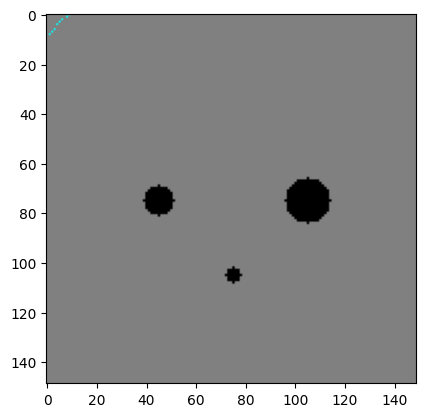

In [12]:
test_experiment.visualize_sensor_mask(index=[slice(0, -1, 1), slice(0, -1, 1), 50])

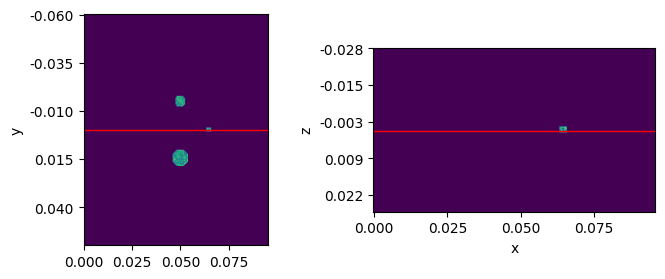

In [13]:
test_experiment.plot_ray_path(0)

In [14]:
test_experiment = experiment.Experiment.load('invitro_arm_experiment')
test_experiment.run(dry=True)

dry run of simulation


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00,  5.36it/s]


In [15]:
test_experiment.run(repeat=True)

running with 5 workers



Process prep_3:
Traceback (most recent call last):
  File "/home/trevor/miniconda3/envs/musik/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/trevor/miniconda3/envs/musik/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/trevor/repos/musik_dev_private/core/experiment.py", line 241, in prep_worker
    index=indices[count],
IndexError: index 0 is out of bounds for axis 0 with size 0


preparation for sim    0 completed in  4.43 seconds
preparation for sim    2 completed in  4.43 seconds
preparation for sim    1 completed in  4.56 seconds
simulation             0 completed in  9.70 seconds
simulation             2 completed in  8.36 seconds
simulation             1 completed in  9.42 seconds


In [16]:
test_experiment.add_results()
test_reconstruction = reconstruction.Compounding(test_experiment)

In [17]:
images = test_reconstruction.compound(workers=24, resolution_multiplier=2.5, local=True, combine=False)

100%|██████████| 3/3 [00:00<00:00, 69136.88it/s]


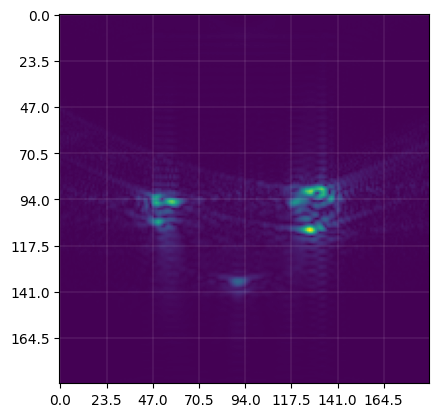

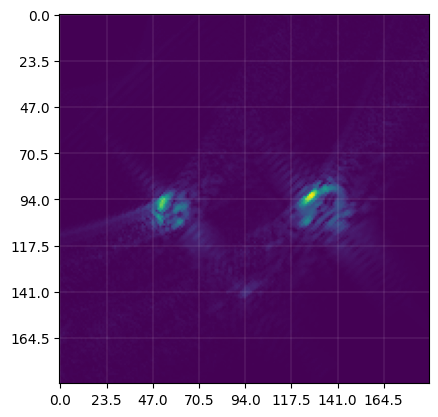

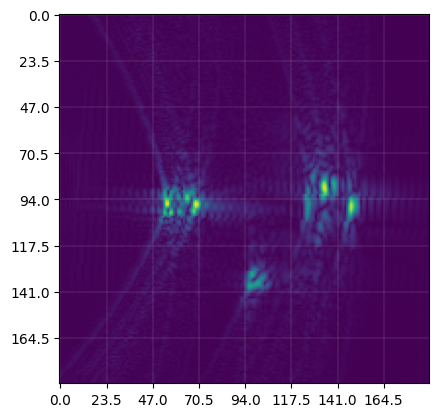

In [18]:
for image in images:
    plt.xticks(np.linspace(0, image.shape[0],9))
    plt.yticks(np.linspace(0, image.shape[1],9))
    plt.imshow(image[:,:,image.shape[2]//2])
    plt.grid(color='w', linestyle='-', linewidth=0.1)
    plt.show()

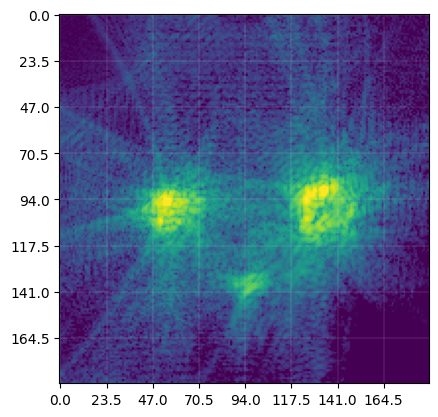

In [19]:
plt.xticks(np.linspace(0, image.shape[0],9))
plt.yticks(np.linspace(0, image.shape[1],9))
plt.imshow(np.log(np.prod(images, axis=0))[:,:,image.shape[2]//2], vmin=20,vmax=35)
plt.grid(color='w', linestyle='-', linewidth=0.1)
plt.show()

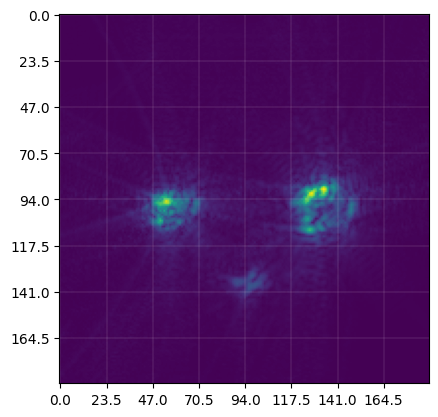

In [20]:
plt.xticks(np.linspace(0, image.shape[0],9))
plt.yticks(np.linspace(0, image.shape[1],9))
plt.imshow(np.sum(images, axis=0)[:,:,image.shape[2]//2])
plt.grid(color='w', linestyle='-', linewidth=0.1)
plt.show()

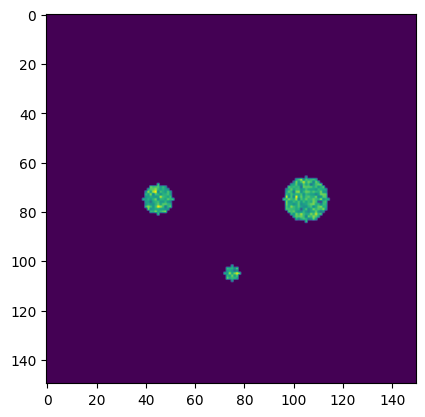

In [21]:
plt.imshow(test_phantom.get_complete()[0,:,:,test_phantom.get_complete().shape[3]//2])

In [22]:
test_reconstruction = reconstruction.DAS(experiment=test_experiment)
signals = test_reconstruction.get_signals(dimensions=2, matsize=128, downsample=0.5, workers=16, tgc=10)

100%|██████████| 3/3 [00:00<00:00,  7.22it/s]


AttributeError: 'Planewave' object has no attribute 'make_scan_line'

In [ ]:
fig, ax = plt.subplots(1, len(test_reconstruction.transducer_set), figsize=(20, 5))
for i in range(len(test_reconstruction.transducer_set)):
    ax[i].imshow(signals[i], vmin=0, vmax=200000)

In [ ]:
image = test_reconstruction.get_image(dimensions=2, matsize=128, downsample=0.5, workers=16, tgc=10)
plt.imshow(image, vmin=0, vmax=200000)

In [ ]:
plt.imshow(image, vmin=0, vmax=50000)


In [ ]:
plt.imshow(test_phantom.get_complete()[0, :, :, 200], vmin=1500, vmax=2000)


In [ ]:
# test_reconstruction = reconstruction.Compounding(experiment=test_experiment)
# images = test_reconstruction.compound(workers=24, resolution_multiplier=1, local=True, combine=True)

In [ ]:
images.shape

In [ ]:
plt.imshow(images[:, :, images.shape[2]//2])

In [ ]:
plt.imshow(test_phantom.get_complete()[0, :, :, 200], vmin=1500, vmax=2000)


In [ ]:
plt.imshow(images[:, :, images.shape[2]//2])

In [ ]:
images.shape

In [ ]:
image = test_reconstruction.get_image(dimensions=2, matsize=128, downsample=0.5, workers=16, tgc=10)

In [ ]:
plt.imshow(image)

In [ ]:
plt.imshow(image)

In [ ]:
plt.imshow(test_phantom.get_complete()[0, :, :, 200])


In [ ]:
plt.imshow(image)

In [ ]:
plt.plot(test_experiment.results[9][1][0])

In [ ]:
test_experiment.results[0][1][0]